# Preliminary
In this notebook I want to get a sense about the two biggest challenges i see in my proposal architecture and the Optional Multi Task loss function, where sometimes some of the tasks are not defined. This will also give me insight in the computational requirements of this network. 

I will make use of a smaller dataset from epicurious.com and jamieoliver.com. For this purpose I make use of the https://github.com/brandonmburroughs/RecipesScraper scraper.

## Dataset
Our dataset consist of large json files. We got about 27,500 recipes from epicurious and 2,300 from jamieoliver.com.   Since we want to base our architecture on a convolutional neural network we need to set a fixed size for the ingredient text size and a fixed size for the number of ingredients. We can pad the smaller ingredients or recipes, but still the larger our fixed sizes the slower our training will be. To get a sense of what make sense we will first count the ingredient sizes and the recipe sizes. 

For each recipe we have a name, a list of ingredients and a list of tags. The basically is a catch all tag field that includes cusine, type of meal. 

In [3]:
import os
import json 
import matplotlib.pyplot as plt
import operator
from IPython.display import HTML, display
import numpy as np
%matplotlib inline

### Statistics
Some simple statistics about or dataset to come decide on our max character length and max recipe size

Found 246696 in epicurious_recipes.json
Found 2335 in jamieoliver_recipes.json


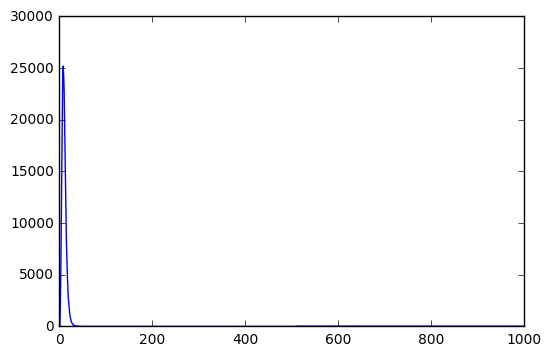

16 0.9
19 0.95
21 0.975
31 0.995
172 0.999


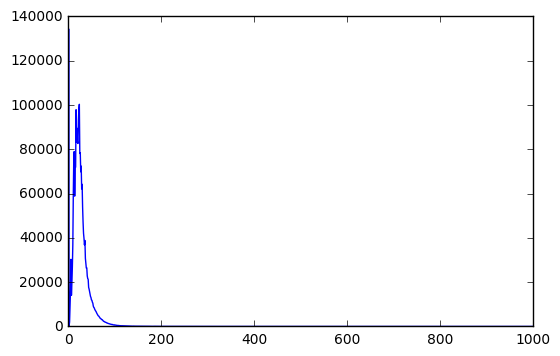

46 0.9
58 0.95
71 0.975
91 0.99
207 0.999


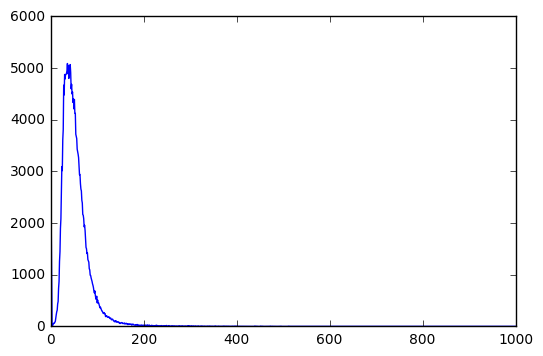

86 0.9
104 0.95
129 0.975
259 0.995
483 0.999


American: 95373,Bake: 56451,Quick & Easy: 47599,Dessert: 43111
Dinner: 37219,Side: 29644,Vegetarian: 26951,Vegetable: 24096
Chicken: 21855,Soup/Stew: 21808,Appetizer: 19834,Healthy: 19466
Italian: 18544,Salad: 16560,Fruit: 15044,Beef: 15039
Peanut Free: 14687,Soy Free: 14345,Cheese: 13673,Cake: 13577
Wheat/Gluten-Free: 13546,Chocolate: 13214,Bon Appétit: 12890,Tree Nut Free: 12508
Sauté: 12097,Kosher: 11863,Cookies: 11691,Egg: 11475
Breakfast: 11382,No-Cook: 11371,Kid-Friendly: 11222,Pasta: 11213
Pescatarian: 10995,Bread: 10703,Fish: 10688,Christmas: 9835
Tomato: 9473,Potato: 9300,Summer: 9274,Gourmet: 9253
Pork: 9053,Mexican: 8620,Bean: 8445,Thanksgiving: 8370


In [10]:
JSON_FOLDER = '../RecipesScraper/output/'

def _extract_tags(recipe):
    if type(recipe['tags']) is not list:
        recipe['tags'] = [recipe['tags']]
    for tag in recipe['tags']:
        if type(tag) is not list:
            yield tag  
        else:
            for t in tag:
                yield t
    
    
def get_ds_statictics(folder):
    ingredient_sizes = {}
    max_ing_size_per_recipe = {}
    recipe_sizes = {}
    tags = {}
    
    for filename in os.listdir(folder):
        json_file = os.path.join(folder, filename)
        
        if os.path.isfile(json_file) and filename[-5:] == '.json':
            with open(json_file,'r') as io:
                data = json.load(io)
            print "Found %d in %s" % (len(data['recipes']), filename)
            for recipe in data['recipes']:
                for t in _extract_tags(recipe):
                    if t not in tags:
                        tags[t] = 0
                    tags[t] += 1
                recipe_len = len(recipe['ingredients'])
                if recipe_len not in recipe_sizes:
                    recipe_sizes[recipe_len] = 0
                recipe_sizes[recipe_len] += 1
                ing_size = 0
                for ingredient in recipe['ingredients']:
                    ingredient_len = len(ingredient)
                    if ingredient_len not in ingredient_sizes:
                        ingredient_sizes[ingredient_len] = 0
                    if ingredient_len > ing_size:
                        ing_size = ingredient_len
                    ingredient_sizes[ingredient_len] += 1
                if ing_size not in max_ing_size_per_recipe:
                    max_ing_size_per_recipe[ing_size] = 0
                max_ing_size_per_recipe[ing_size] += 1
                
    return ingredient_sizes, max_ing_size_per_recipe, recipe_sizes, tags
                    
                
def print_percentages(counts, percent=[.9,.95,.975,.99,.999]):
    total = float(sum(counts.values()))
    till_now = 0
    for x,y in counts.iteritems():
        till_now += y
        if till_now/total >= percent[0]:
            print x,percent[0]
            percent = percent[1:]
            
        
        if len(percent) < 1:
            break
    

ingredient_sizes, max_ing_size_per_recipe, recipe_sizes, tags = get_ds_statictics(JSON_FOLDER)
display(HTML("<h3>Recipes</h3>"))
plt.plot(recipe_sizes.keys(), recipe_sizes.values())
plt.show()
print_percentages(recipe_sizes, percent=[.9,.95,.975,.995,.999])

display(HTML("<h3>Ingredients</h3><p>We inspect the distribution of the number of  characters per ingredient and of the longest per recipe. The latter is usefull if we want to discard recipes with to long ingredient sizes.</p><h4>Ingredient sizes</h4>"))
plt.plot(ingredient_sizes.keys(), ingredient_sizes.values())
plt.show()
print_percentages(ingredient_sizes)
display(HTML("<h4>Longest ingredient length</h4> "))
plt.plot(max_ing_size_per_recipe.keys(), max_ing_size_per_recipe.values())
plt.show()
print_percentages(max_ing_size_per_recipe, percent=[.9,.95,.975,.995,.999])

display(HTML("<h3>Tags</h3>"))
#sort tags to show top N
tags = sorted(tags.items(), key=operator.itemgetter(1),reverse=True)
N = 100
PER_ROW = 4
row = ""
counter = 0

html = "<table><tbody><tr>"
for t,c in tags:
    counter +=1
    html += "<td><strong>%s</strong>: %d</td>" % (t,c)
    if counter % PER_ROW == 0:
        html += "</tr><tr>"
    if counter > N:
        break
html += "</tr></tbody></table>"
    
display(HTML(html)) 
display(HTML("<h3>Names</h3>"))

We can do something with the meal names and something with the cusine and 

### Build dataset
We will fix the ingredient text size to 128 or 256 characters and set the number of ingredients to 32. We will compare performance for text size in terms of performance and task performance. We will remove the complete recipe if the number of ingredients or text size exceeds the limit. 

We are going to build a dataset with the following data per recipe:
- **X_char**: Each recipe thus consists of a 32x(128|256) matrix of 8-bit unsigned integers. With 8-bit integers we can represents alphabet size up to 255 characters 
- **X_words**: Set of 32-bit integers representing the words of the ingredients of the recipe, can be used as simple bag-of-words baseline
- **Y_name**: Set of 16-bit integers representing the words in the name of the words, names that occur less then 5 times will be removed from this list
- **Y_vegetarian**: 8-bit integer 0 if not known, 1 if vegetarian, 2 if not vegatarian. 
- **Y_cusine**: 8-bit integer 0 if not know, idx number depending on the list of cuisines given for every other cuisine

We will also build the following vocabularies along with the data above:
- **Alphabet:** The alphabet used to learn this data
- **Ingredient words:** For the words found in the ingredients
- **Name words:** For the words found in the names

Please note that we assume that the tags are always correctly used. So a meal is nog tagged with containing meat and being vegetarian at the same time


So we will represent the ingredients lists as a of 118 sequence of 8-bit unsigned integers. We will do the one-hot-encoding on run-time. We will pad with 0 and replace unknown chars with 0. Some research suggests that case sensitivity can matter so keep that option open

In [21]:
from timeit import timeit
voc_dic = dict([(a,a%100) for a in xrange(10000)])
voc_lst = [a + 100 for a in xrange(10000)]
print timeit('[voc_dic[x] for x in [1,1000,2500,7500]]',"from __main__ import voc_dic",number=10000)
print timeit('[voc_lst.index(x) for x in [101,1000,2500,7500]]',"from __main__ import voc_lst",number=10000)

0.00628900527954
1.83426403999


In [37]:
# By default we use the hash of arguments of build_dataset to cache the dataset. 
CACHE_FOLDER = ".cache/" #set to NONE to prevent caching behaviour

VEGAN = ['vegetarian','vegan']
MEAT = ['fish','chicken','pork','beef','pork recipes','lamb','beef recipes','duck','duck recipes','turkey','turkey recipes','seafood recipes','seafood','lamb recipes']
CUISINES = ['italian','asian','american','french','indian','british','mexican','chinese','mediterranean']

def create_alphabet(case_sensitive=True, digits=True, others="%.&[]()%!~-+ "):
    """ Creates dictionary from character to integer index, also creates inverse
    """
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    if case_sensitive:
        alphabet += alphabet.upper()
    if digits:
        alphabet += "0123456789"
    alphabet += others
    # 0 is catch all
    return dict([(a,i+1) for i,a in enumerate(alphabet)]),dict([(i+1,a) for i,a in enumerate(alphabet)])


def tokenize(line):
    line = line.replace("<br>", " ").replace(". ", " <eos> ").lower()
    for token in re.findall("[\w\<\>]+", line, re.UNICODE):
        yield token

def _determine_labels(recipe):
    veg = 0
    cus = 0
    for t in _extract_tags(recipe):
        t = t.lower()
        if t in vegetarian:
            veg = 1
        elif t in meat:
            veg = 2
        if t in cusines:
            cus = cusines.index(t) + 1
    return veg,cus

def _read_recipes(folder):
    for filename in os.listdir(folder):
        json_file = os.path.join(folder, filename)
        if os.path.isfile(json_file) and filename[-5:] == '.json':
            with open(json_file,'r') as io:
                data = json.load(io)
                for recipe in data['recipes']:
                    yield recipe

def find_chars(ingredient, text_size, max_text_size):
    chars = []
    for ci in xrange(max_text_size):
        if ci < text_size and ingredient[ci] in char2int:
            chars.append(char2int[ingredient[ci]])
        else:
            chars.append(0) #padding and catch-all
    return chars

def map_word_sequence(input_string, inv_voc):
    """
    Tokenizes a string into sequence of ints, based on vocobulary
    """
    seq = []
    for token in tokenize(input_string):
        if token not in inv_voc:
            inv_voc[token] = len(inv_voc)
        seq.append(inv_voc[token])
    return seq
        
    

def build_dataset(folder, case_sensitive=True, digits=True, others="%.&[]()%!~-+ ",cusines=CUISINES,vegetarian=VEGAN,meat=MEAT,name_th=5,max_text_size=128,max_recipe_size=32):
    char2int, int2char = create_alphabet(case_sensitive, digits, others)
    if len(int2char) > 255:
        raise Exception("Alphabet size of %d exceeds maximum of 255 characters")
    X_char = []
    X_words = []
    voc_ingredients = {}
    voc_names = {}
    
    Y_cuisine = []
    Y_vegetarian = []
    Y_names = []
    counter = 0
    
    for recipe in _read_recipes(folder):
        chars = []
        words = []
        
        #Ingredients:
        if len(recipe['ingredients']) > max_recipe_size:
            continue
        for ingredient in recipe['ingredients']:
            #chars
            l = len(ingredient)
            if l > max_text_size:
                continue
            if not case_sensitive:
                ingredient.lower()
            chars.append(find_chars(ingredient, text_size, max_text_size))
            words.append(map_word_sequence(ingredient,voc_ingredients))
        
        #name
        names = (map_word_sequence(recipe['name'],voc_names))
        
        X_char.append(chars)
        X_words.append(words)
        Y_names.append(names)
        
        # Label:
        veg,cus = _determine_labels(recipe)
        Y_cuisine.append(cus)
        Y_vegetarian.append(veg)
        
        
    #Here something that thresholds  
    
    #here something that save to npz file
        
    return (X_char, X_words, X_names),(Y_names,Y_cuisine,Y_vegetarian), (voc_ingredients,voc_names)

def plot_ds_statistics():
    


In [42]:
print len(Y_cuisine),len([x for x in Y_cuisine if x > -1])
print len(Y_vegetarian),len([x for x in Y_vegetarian if x > -1])

249031 144649
249031 91025
